In [1]:
import matplotlib.pyplot as plt
# import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, f1_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score

from sklearn.feature_extraction.text import TfidfVectorizer

import time
import torch
import tqdm
import copy
import numpy as np
import pandas as pd

# import nltk
# from wordcloud import WordCloud 
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.tokenize import wordpunct_tokenize
# from nltk.stem import WordNetLemmatizer


# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader

# Load Data from .csv file
df = pd.read_csv("./TalkFile_ner_2.csv")
df.drop(['Sentence #', 'POS'], axis=1, inplace=True)
df = df.dropna()  # Remove Blank Text

# Limit data within in the first xxx line if needed
df = df.iloc[:8192]

df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8192 entries, 0 to 8191
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  8192 non-null   object
 1   Tag       8192 non-null   object
dtypes: object(2)
memory usage: 128.1+ KB


,Sentence,Tag
0,Thousands of demonstrators have marched throug...,"['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '..."
1,Families of soldiers killed in the conflict jo...,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2,They marched from the Houses of Parliament to ...,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."


In [2]:
all_words = " ".join(df["Sentence"]).split()

In [3]:
all_words[1:5]

['of', 'demonstrators', 'have', 'marched']

In [4]:
# Word indexing and Vectorization
word2idx = {'<pad>': 0}
word2idx.update({word: idx+1 for idx, word in enumerate(set(all_words))})
vocab_size = len(word2idx)
vocab_size 

14640

In [5]:
Sentences = df["Sentence"].str.split()
Sentences[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [6]:
# Remove square brackets, commas, and quotation marks from the "Tag" column
df["Tag_stripe"] = df["Tag"].str.replace(r"[\[\]',]", '', regex=True)

# Combine all values in the "Tag" column into a single string
cleaned_tags = " ".join(df["Tag_stripe"]).split()

# Get unique tags
unique_tags = set(cleaned_tags)

In [7]:
df["Tag_stripe"]

0       O O O O O O B-geo O O O O O B-geo O O O O O B-...
1       O O O O O O O O O O O O O O O O O O B-per O O ...
2                     O O O O O O O O O O O B-geo I-geo O
3                           O O O O O O O O O O O O O O O
4       O O O O O O O O O O O B-geo O O B-org I-org O ...
                              ...                        
8187    O B-geo B-tim O B-geo O O O B-per I-per O O O ...
8188    O B-tim O B-gpe O B-per O B-per I-per O O O O ...
8189    O O O O O O O O O O B-geo O O B-gpe O O O O O ...
8190    B-org I-org O O O O O O O O O O O O O O O O B-...
8191                                    O O O O O O O O O
Name: Tag_stripe, Length: 8192, dtype: object

In [8]:
unique_tags

{'B-art',
 'B-eve',
 'B-geo',
 'B-gpe',
 'B-nat',
 'B-org',
 'B-per',
 'B-tim',
 'I-art',
 'I-eve',
 'I-geo',
 'I-gpe',
 'I-nat',
 'I-org',
 'I-per',
 'I-tim',
 'O'}

In [9]:
from itertools import chain
list_labels = ['O'] + [i for i in list(unique_tags) if i !='O']

label2ind = {}
ind2label = {}
for ind, i in enumerate(list_labels):
    label2ind[i]=ind
    ind2label[ind]=i

In [10]:
ind2label

{0: 'O',
 1: 'B-art',
 2: 'B-org',
 3: 'B-tim',
 4: 'I-nat',
 5: 'I-eve',
 6: 'I-per',
 7: 'B-nat',
 8: 'B-eve',
 9: 'B-per',
 10: 'I-org',
 11: 'I-geo',
 12: 'I-art',
 13: 'I-gpe',
 14: 'B-gpe',
 15: 'I-tim',
 16: 'B-geo'}

In [11]:
label2ind

{'O': 0,
 'B-art': 1,
 'B-org': 2,
 'B-tim': 3,
 'I-nat': 4,
 'I-eve': 5,
 'I-per': 6,
 'B-nat': 7,
 'B-eve': 8,
 'B-per': 9,
 'I-org': 10,
 'I-geo': 11,
 'I-art': 12,
 'I-gpe': 13,
 'B-gpe': 14,
 'I-tim': 15,
 'B-geo': 16}

In [12]:
# +1 for <pad>
num_class = len(label2ind) + 1

In [13]:
# Function to encode a list of words upto max_length
def encode_sentence(words, word2idx, max_length):
    # Encode words into indices, using 0 for unknown words
    encoded = [word2idx.get(word, 0) for word in words]
    
    # Pad or truncate the list to match max_length
    if len(encoded) < max_length:
        encoded.extend([0] * (max_length - len(encoded)))  # Pad with zeros
    else:
        encoded = encoded[:max_length]  # Truncate to max_length
    
    return encoded

# Encode each list of words
MAX_LEN = max(len(x) for x in Sentences)  # Ensure you have defined max_len appropriately
max_len = MAX_LEN

df["Encoded_Words"] = Sentences.apply(lambda words: encode_sentence(words, word2idx, max_len))
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8192 entries, 0 to 8191
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sentence       8192 non-null   object
 1   Tag            8192 non-null   object
 2   Tag_stripe     8192 non-null   object
 3   Encoded_Words  8192 non-null   object
dtypes: object(4)
memory usage: 256.1+ KB


,Sentence,Tag,Tag_stripe,Encoded_Words
0,Thousands of demonstrators have marched throug...,"['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '...",O O O O O O B-geo O O O O O B-geo O O O O O B-...,"[11804, 3818, 11591, 5909, 5496, 14054, 1392, ..."
1,Families of soldiers killed in the conflict jo...,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...",O O O O O O O O O O O O O O O O O O B-per O O ...,"[11507, 3818, 12475, 11697, 8840, 1335, 3312, ..."
2,They marched from the Houses of Parliament to ...,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...",O O O O O O O O O O O B-geo I-geo O,"[6016, 5496, 8755, 1335, 2811, 3818, 10290, 65..."
3,"Police put the number of marchers at 10,000 wh...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...",O O O O O O O O O O O O O O O,"[14297, 11726, 1335, 2517, 3818, 3133, 7271, 4..."
4,The protest comes on the eve of the annual con...,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...",O O O O O O O O O O O B-geo O O B-org I-org O ...,"[9144, 14256, 10751, 10876, 1335, 179, 3818, 1..."


In [14]:
# Function to encode a list of POS or NER labels up to max_length
def label_vectors(labels, max_length):
    # Encode words into indices, using 0 for unknown words
    encoded = [label2ind.get(label, len(label2ind)) for label in labels.split()]  # Use .get to handle unknown labels
    
    # Pad or truncate the list to match max_length
    if len(encoded) < max_length:
        encoded.extend([len(label2ind)] * (max_length - len(encoded)))  # Pad with len(label2ind)
    else:
        encoded = encoded[:max_length]  # Truncate to max_length
    
    return encoded

# Apply the function to the 'Tag' column and create a new column 'Label_Words'
df["Label_Words"] = df["Tag_stripe"].apply(lambda labels: label_vectors(labels, max_len))

df.drop(['Sentence', 'Tag_stripe', 'Tag'], axis=1, inplace=True)

In [15]:
# Train-Test Split of the Dataset
X = df["Encoded_Words"].tolist()
Y = df["Label_Words"].tolist()

X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, train_size=0.8, random_state=101)

# One hot for multi-class classification
# NER = 17 classes [0-16] ==> num_class = 17 + 1 (padding)
Y_trn_Oh = np.zeros((len(Y_trn), max_len, num_class))
Y_tst_Oh = np.zeros((len(Y_tst), max_len, num_class))

for i, y in enumerate(Y_trn):
    Y_trn_Oh[i, np.arange(len(y)), y] = 1

for i, y in enumerate(Y_tst):
    Y_tst_Oh[i, np.arange(len(y)), y] = 1

# Initialize an Embedding layer from Torch
vocab_size = len(word2idx)

# Convert to word_vector Tensor 
X_train = torch.tensor(X_trn, dtype=torch.long)
Y_train = torch.tensor(Y_trn_Oh, dtype=torch.float32)

X_test = torch.tensor(X_tst, dtype=torch.long)
Y_test = torch.tensor(Y_tst_Oh, dtype=torch.float32)

print(Y_test[0])

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [16]:
# Build Custom Module for logistic Regression
class LogisticRegressionLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(LogisticRegressionLSTM, self).__init__()
        self.word_embedding = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        
        # The linear layer that maps from hidden state space to tag space / class
        self.linear = nn.Linear(hidden_dim, num_classes)

    def forward(self, sentence):
        sentence = sentence.long()  # Convert input tensor to LongTensor for embedding layer input
        embeds = self.word_embedding(sentence)  # Shape: (batch_size, sequence_length, embedding_dim)
        lstm_out, _ = self.lstm(embeds)  # Shape: (batch_size, sequence_length, hidden_dim)
        y_pred = self.linear(lstm_out)  # Shape: (batch_size, sequence_length, output_dim)
        return y_pred
        
# Instantiate the model
torch.manual_seed(27)
# num_class = 17
# vocab_size = 35177
embedding_dim = 32
lstm_hidden_dim = 16

model = LogisticRegressionLSTM(vocab_size, embedding_dim, lstm_hidden_dim, num_class)

print("checking parameters: ", model.state_dict())

# Defining Binary Cross-Entropy loss
criterion = torch.nn.CrossEntropyLoss()

checking parameters:  OrderedDict([('word_embedding.weight', tensor([[ 1.7650,  0.0664, -0.0706,  ...,  0.5088,  1.2001,  1.0033],
        [ 0.2068, -0.6710,  0.4601,  ..., -1.6494, -0.8828,  0.4444],
        [ 0.4656, -0.8964,  0.5814,  ...,  0.1931,  0.5177,  0.1250],
        ...,
        [ 0.9063,  0.0071,  2.0323,  ..., -0.6262, -1.2594, -0.8737],
        [-1.0977, -0.9847, -0.5682,  ...,  3.3623,  1.6205,  0.0170],
        [ 1.7196,  0.9410, -0.0274,  ...,  1.6649,  0.4239, -0.7282]])), ('lstm.weight_ih_l0', tensor([[ 0.1542,  0.0557, -0.1086,  ...,  0.1616,  0.0609,  0.0606],
        [-0.0311, -0.0700, -0.0055,  ...,  0.1401, -0.1325,  0.2127],
        [-0.0019,  0.2105,  0.0734,  ..., -0.1123, -0.1202, -0.0586],
        ...,
        [ 0.0142,  0.1700, -0.1445,  ...,  0.0162,  0.1360, -0.1954],
        [-0.2420, -0.1140, -0.0293,  ..., -0.1045, -0.1317, -0.2325],
        [ 0.2127,  0.0626,  0.0050,  ..., -0.1010, -0.0311,  0.2404]])), ('lstm.weight_hh_l0', tensor([[ 0.0605,  0.07

Input: 8192 sentences up to 70 words, Word embedding: vocab_size 14640 embedding_dim 32
epoch: 1/128, loss: 15.209515571594238 - 0% complete, 1.6505391597747803 elapsed
epoch: 13/128, loss: 14.2969388961792 - 10% complete, 22.259016036987305 elapsed
epoch: 25/128, loss: 14.280817985534668 - 19% complete, 46.82952117919922 elapsed
epoch: 37/128, loss: 14.274821281433105 - 28% complete, 68.46815466880798 elapsed
epoch: 49/128, loss: 14.269701957702637 - 38% complete, 89.74947142601013 elapsed
epoch: 61/128, loss: 14.266219139099121 - 47% complete, 111.00031423568726 elapsed
epoch: 73/128, loss: 14.264802932739258 - 57% complete, 132.83511900901794 elapsed
epoch: 85/128, loss: 14.264358520507812 - 66% complete, 157.05080604553223 elapsed
epoch: 97/128, loss: 14.264178276062012 - 75% complete, 181.18426823616028 elapsed
epoch: 109/128, loss: 14.264158248901367 - 85% complete, 205.90790152549744 elapsed
epoch: 121/128, loss: 14.264225959777832 - 94% complete, 232.0024528503418 elapsed
Loss:

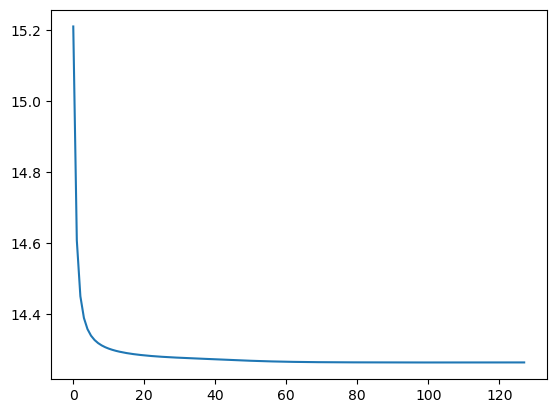

OrderedDict([('word_embedding.weight', tensor([[ 4.8508e-01,  2.1812e-01, -8.4869e-02,  ...,  5.3807e-02,
          4.4635e-02,  1.0922e-01],
        [ 2.0617e-07,  8.5532e-08, -9.5767e-08,  ..., -1.1306e-07,
         -2.0267e-08,  8.1572e-08],
        [ 1.4639e-04, -3.8370e-05, -8.2182e-06,  ..., -1.0403e-05,
          9.5050e-06,  2.2668e-05],
        ...,
        [-1.8066e-05,  1.2416e-05, -2.2915e-05,  ..., -3.6034e-06,
          1.5475e-06, -4.0962e-06],
        [ 7.3045e-06,  1.8976e-06, -1.9468e-06,  ...,  3.8831e-03,
         -1.3408e-06, -6.3042e-06],
        [-1.5481e-04, -9.9102e-05,  3.2838e-05,  ..., -1.7248e-05,
          3.3287e-05, -3.7463e-05]])), ('lstm.weight_ih_l0', tensor([[ 0.0368,  0.0167, -0.0068,  ...,  0.0042,  0.0032,  0.0087],
        [ 0.0694,  0.0310, -0.0122,  ...,  0.0078,  0.0064,  0.0156],
        [ 0.0578,  0.0259, -0.0105,  ...,  0.0067,  0.0053,  0.0131],
        ...,
        [ 0.0611,  0.0274, -0.0108,  ...,  0.0068,  0.0056,  0.0137],
        [ 0.

In [17]:
# Hold the best model
best_loss = np.inf   # init to infinity
best_weights = None
history = []

# Training parameters

n_epochs = 128  # number of epochs to run
batch_size = 64 # size of each batch

batch_start = torch.arange(0, len(X_train), batch_size)
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay = 1e-2)
#optimizer = optim.SGD(model.parameters(), lr=0.01)

t = time.time()

print(f"Input: {len(X)} sentences up to {max_len} words, Word embedding: vocab_size {vocab_size} embedding_dim {embedding_dim}")

# training loop
for epoch in range(n_epochs):
    if epoch % (n_epochs//10) == 1:
        elapsed = time.time() - t
        print(f"epoch: {epoch}/{n_epochs}, loss: {loss} - {epoch * 100 // n_epochs}% complete, {elapsed} elapsed")
        
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            Y_batch = Y_train[start:start+batch_size]
            
            # Ensure Y_batch is a 1D tensor of class indices
            # Y_batch = Y_batch.view(-1)

            # Check if input indices are within the valid range
            if X_batch.max().item() >= vocab_size or X_batch.min().item() < 0:
                raise ValueError("Input contains indices outside the range of the embedding layer")
            
            # forward pass
            output = model(X_batch)           
            loss = criterion(output, Y_batch)
                                 
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # update weights
            optimizer.step()
            
            # print progress
            bar.set_postfix(loss=float(loss)) 
            
    # evaluate accuracy at end of each epoch
    Y_pred = model(X_test)
    loss = criterion(Y_pred, Y_test)
    history.append(loss)
    if loss < best_loss:
        best_loss = loss
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
history_np = [h.detach().numpy() for h in history]

print("Loss: %.2f" % best_loss)
plt.plot(history_np)
plt.show()

print(best_weights)

In [18]:
with torch.no_grad():
    Y_predicted = model(X_train)             # no need to call model.forward
    Y_predicted = Y_predicted.view([-1, num_class]) # 3D to 2D
    Y_train_2D = Y_train.view([-1, num_class]) # 3D to 2D
    
    Y_predicted_cls = torch.argmax(F.softmax(Y_predicted, dim=1), dim=1)  # Round off to nearest class
    Y_train_cls = torch.argmax(F.softmax(Y_train_2D, dim=1), dim=1)
    acc_train = Y_predicted_cls.eq(Y_train_cls).sum() / float(Y_train_cls.shape[0])  # accuracy

with torch.no_grad():
    Y_predicted = model(X_test)             # no need to call model.forward()
    Y_predicted = Y_predicted.view([-1, num_class]) # 3D to 2D
    Y_test_2D = Y_test.view([-1, num_class]) # 3D to 2D
    
    Y_predicted_cls = torch.argmax(F.softmax(Y_predicted, dim=1), dim=1)  # Round off to nearest class
    Y_test_cls = torch.argmax(F.softmax(Y_test_2D, dim=1), dim=1)
    acc_test = Y_predicted_cls.eq(Y_test_cls).sum().item() / float(Y_test_cls.shape[0])  # accuracy

In [19]:
print(f"Input: {len(X)} sentences up to {max_len} words, Word embedding: vocab_size {vocab_size} embedding_dim {embedding_dim}")
print(f'accuracy with train set = {acc_train:.4f}')
print(f'accuracy with test set = {acc_test:.4f}')

Input: 8192 sentences up to 70 words, Word embedding: vocab_size 14640 embedding_dim 32
accuracy with train set = 0.9519
accuracy with test set = 0.9531
